In [550]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from scipy.linalg import norm, pinv
from scipy import fft

In [551]:
import torch
from torch.nn.functional import relu, mse_loss

ttype = torch.float32
device = torch.device('cpu')

In [572]:
''' LISTA Functions'''
class sparse_dataset(Dataset):
    def __init__(self, N, K, Nexamples):
        self.X = np.zeros((Nexamples, N, 1))
        for ii in range(Nexamples):
            self.X[ii,...] = self.generate_sparse_vector(N, K)
        #self.X *= np.random.randn(*self.X.shape)
        self.X = torch.from_numpy(self.X)
    
    def __getitem__(self, i):
        return self.X[i, ...]
    
    def __len__(self, ):
        return self.X.shape[0]
    
    def generate_sparse_vector(self, N, K):
        x = np.zeros((N,1))
        x[:K,...] = 1.
        np.random.shuffle(x)
        return x
    


def pbnet(A, alpha, lamb, x0, xt, K, testFlag=True, explicit_grad=True):

    x = x0.detach().clone()
    x.requires_grad = True

    y_meas = Aop(A, xt)
    
    if explicit_grad:
        AHA = torch.matmul(torch.transpose(A, 0, 1), A)
        AHy = torch.matmul(torch.transpose(A, 0, 1), y_meas)

    if testFlag: y_meas = y_meas.detach()
    
    losslist = []
        
    for kk in range(K):
        y_est = Aop(A,x)
        res = y_est - y_meas
        loss_dc = torch.sum(res**2)
        if explicit_grad:
            g = torch.matmul(AHA, x) - AHy
        else:
            g = torch.autograd.grad(loss_dc, 
                                    x, 
                                    create_graph = not testFlag)[0]
        
        x = x - alpha*g           # gradient update
        x = softthr(x, lamb*alpha)   # proximal update
        
        with torch.no_grad():
            loss = loss_dc + lamb * torch.sum(torch.abs(x))
            losslist.append(loss.cpu().detach().numpy())
    return x, losslist

In [573]:
def Aop(A, x):
    return torch.matmul(A,x)
def softthr(x, thr):
    return torch.sign(x) * relu(torch.abs(x) - thr)
def listaNet(A, alpha, lamb, x_init, x_true, maxit, testFlag=True):
    x = x_init.detach().clone()
    x.requires_grad = True
        
    y_meas = Aop(A, x_true)
    
    AHA = torch.matmul(torch.transpose(A, 0, 1), A)
    AHy = torch.matmul(torch.transpose(A, 0, 1), y_meas)
    
    
    if testFlag:
        y_meas = y_meas.detach()
        
    losslist = []
    
    # run iterations
    for k in range(maxit):
        y_est = Aop(A, x)
        
        loss_term1 = mse_loss(y_est, y_meas)
        g = torch.matmul(AHA, x) - AHy
        
        # ISTA update
        x = softthr(x - alpha[k]*g, lamb[k]*alpha[k])
        with torch.no_grad():
            loss = loss_term1 + lamb[k] * torch.sum(torch.abs(x)) # LASSO loss function
            losslist.append(loss.cpu().detach().numpy())
    return x, losslist

In [574]:
# Create ULA and Nested Array Matricies
M = 70
N = 100
sig = 0
N1 = M // 2
N2 = M - N1

inner = np.arange(N1)
outer = np.arange(1, N2+1)*(N1 + 1) - 1

uniform = np.arange(M).reshape(-1,1)
nested = np.concatenate([inner, outer]).reshape(-1, 1)

fgrid = fft.fftfreq(N).reshape(-1, 1)

complex_exp = lambda x : np.exp(1j* 2*np.pi * x )
A_u = complex_exp(uniform @ fgrid.T)
A_n = complex_exp(nested @ fgrid.T)

np.set_printoptions(precision=3, suppress=True)

In [575]:
# Create learnable parameters for training ULA LISTA
maxit = 20

A = A_u
#A = np.random.randn(M, N)
L = np.max(np.abs(np.linalg.eigvals(A.conj().T @ A)))
A_repr = A
A_repr = np.block([
    [A.real, -A.imag],
    [A.imag, A.real]
])
A = torch.from_numpy(A_repr).to(device).to(ttype)
A = A.detach().clone()
A.requires_grad = True

x_init = torch.randn([2*N, 2]).to(ttype)
# x_init = torch.randn([N, 1]).to(ttype)
x_init = x_init.detach().clone()

alpha = torch.ones([100]).to(device).to(ttype) * 1/L
alpha = alpha.detach().clone()
alpha.requires_grad = True

lamb = torch.ones([100]).to(ttype) * 3
lamb = lamb.detach().clone()
lamb.requires_grad = True

optim = torch.optim.Adam([
    #{'params' : [A], 'lr' : 1e-3},
    {'params' : [alpha], 'lr' : 1e-4},
    {'params' : [lamb], 'lr' : 1e-4}
])

print(alpha, lamb, optim)

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], requires_grad=True) tensor([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
   

In [576]:
# Create training data
epochs = 20
batchSize = 10
testFreq = 1
trainingPoints = 100
testingPoints = 10
sparsityLevel = 2

dataset_training = sparse_dataset(N, sparsityLevel, trainingPoints)
dataloader_training = DataLoader(dataset_training, 
                                 batch_size = batchSize, shuffle=True)
dataset_testing = sparse_dataset(N, sparsityLevel, testingPoints)
dataloader_testing = DataLoader(dataset_testing, 
                                 batch_size = 1, shuffle=False)
batches = int(trainingPoints/batchSize)
training_losslist = np.zeros(epochs * batches)
testing_losslist = np.zeros(epochs * batches)

In [577]:
# train ULA LISTA
for t in range(epochs):
    for i, sparse_data in enumerate(dataloader_training):
        idx = t * batches + i
        for s in range(batchSize):
            x_true = sparse_data[s, ...].to(device).to(ttype)
            x_l = torch.cat([x_true, torch.zeros_like(x_true)], dim=0)
            x_r = torch.cat([torch.zeros_like(x_true), x_true], dim=0)
            x_true = torch.cat([x_l, x_r], dim=1)
            x_est, listaLoss = listaNet(A, alpha, lamb, x_init, x_true, maxit, testFlag=False)
            
            training_loss = torch.mean((x_est - x_true)**2)
            training_loss.backward()
            
            with torch.no_grad():
                training_losslist[idx] += training_loss
        optim.step()
        optim.zero_grad()

        if idx % testFreq == 0:
            for u, test_data in enumerate(dataloader_testing):
                x0 = x_init.detach().clone().to(device)
                x_test = test_data[0, ...].to(device).to(ttype)
                x_l = torch.cat([x_test, torch.zeros_like(x_test)], dim=0)
                x_r = torch.cat([torch.zeros_like(x_test), x_test], dim=0)
                x_test = torch.cat([x_l, x_r], dim=1)
                x_est, _ = listaNet(A, alpha, lamb, x0, x_test, maxit, testFlag=True)
                testing_losslist[idx] += torch.mean((x_est.cpu() - x_test)**2)
                print("Epoch: {}\t Batch: {}\t Training Loss: {}\t Validation Loss: {}".format(t, i, training_losslist[idx], testing_losslist[idx]), end='\r')


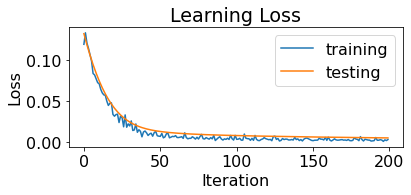

In [578]:
plt.figure(figsize=(6,3))
plt.plot(training_losslist, label='training')
plt.plot(testing_losslist, label='testing')
plt.title('Learning Loss')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.tight_layout()
plt.legend()

In [579]:
x_test = dataset_testing[2].to(device).to(ttype)
x_l = torch.cat([x_test, torch.zeros_like(x_test)], dim=0)
x_r = torch.cat([torch.zeros_like(x_test), x_test], dim=0)
x_test = torch.cat([x_l, x_r], dim=1)

x_pred_learned, _ = listaNet(A, alpha, lamb, x_init, x_true, maxit, testFlag=True)
print(alpha, lamb)
print(1/emax, 3)
x_pred_ista, _ = listaNet(A, 1/emax*np.ones(500), 3*np.ones(500), x_init, x_test, 500, testFlag=True)

x_pred_learned = x_pred_learned.detach().clone().cpu().numpy()
x_pred_ista = x_pred_ista.detach().clone().cpu().numpy()

x_test = x_test.detach().clone().cpu().numpy()

x_p = np.zeros(N, dtype=complex)
x_p.real = x_pred_learned[:N, 0]
x_p.imag = x_pred_learned[N:, 0]
S_pred = np.abs(x_p)

x_p = np.zeros(N, dtype=complex)
x_p.real = x_pred_ista[:N, 0]
x_p.imag = x_pred_ista[N:, 0]
S_pred_ista = np.abs(x_p)

x_t = np.zeros(N, dtype=complex)
x_t.real = x_test[:N, 0]
x_t.imag = x_test[N:, 0]
S_true = np.abs(x_t)

tensor([0.0134, 0.0152, 0.0155, 0.0155, 0.0155, 0.0156, 0.0156, 0.0155, 0.0155,
        0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155, 0.0155,
        0.0156, 0.0156, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100], requires_grad=True) tensor([3.0059, 3.0062, 3.0063, 3.0063, 3.0063, 3.0063, 3.0063, 3.0063, 3.0063,
   

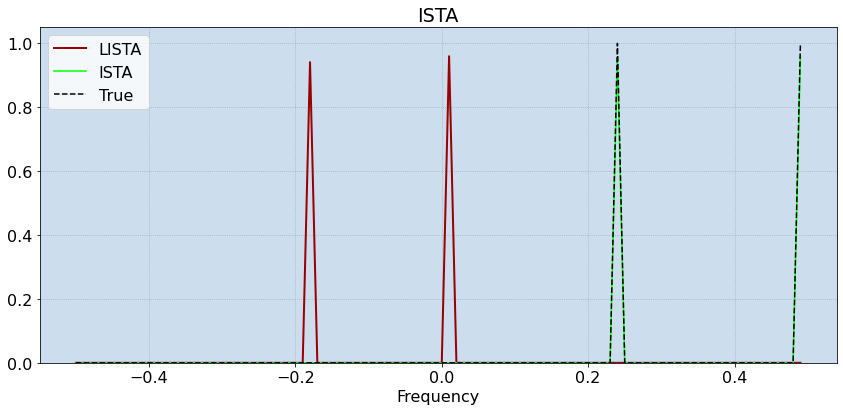

In [582]:
# Plot ULA
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_pred), linewidth=2, color="#990000", label='LISTA')
ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_pred_ista), color='#00FF00', label='ISTA')
ax.plot(fft.fftshift(fft.fftfreq(N)), fft.fftshift(S_true), linestyle='--', color='k', label='True')
y1, y2 = ax.get_ylim()
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('ISTA')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

ax.legend()
plt.tight_layout()
plt.show()

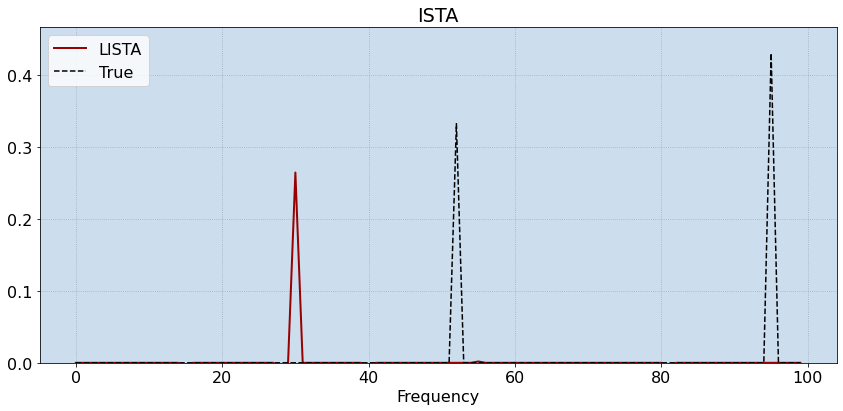

In [562]:
# Plot ULA
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_pred_learned, linewidth=2, color="#990000", label='LISTA')
ax.plot(x_test, linestyle='--', color='k', label='True')
y1, y2 = ax.get_ylim()
ax.set_ylim(0, y2)
ax.set_xlabel('Frequency')
ax.set_title('ISTA')
ax.grid(color='#99AABB', linestyle=':')
ax.set_facecolor('#CCDDEE')

ax.legend()
plt.tight_layout()
plt.show()